In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from control import ss, series, step_response, forced_response

In [4]:
RAD_PER_SEC_TO_RPM = (1 / (2 * np.pi)) * 60
KNOTS_TO_MPS = 0.514444
MPS_TO_KNOTS = 1 / KNOTS_TO_MPS

# Propulsion System

## Propeller

In [43]:
# Propeller linear system
prop_A = np.array([[-1, 1.0], [0, -2]])
prop_B = np.array([[0], [500]])
prop_C = np.array([1, 0])
prop_D = 0

# Make the state space
prop_ss = ss(prop_A, prop_B, prop_C, prop_D)

In [46]:
# Simulate a step response
prop_result = step_response(prop_ss)

# Process results
prop_t = prop_result.time
prop_x = np.squeeze(prop_result.states)

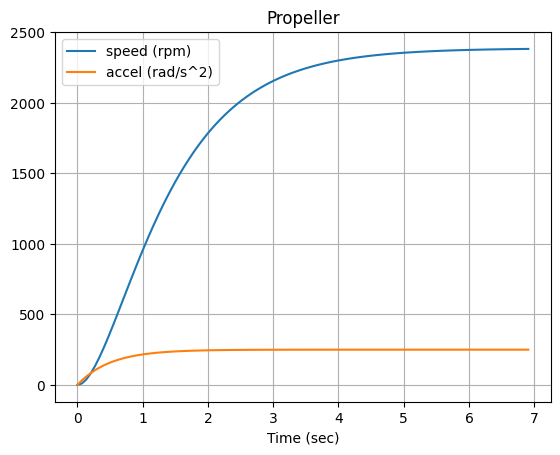

In [47]:
# Plot the results
plt.figure()
plt.grid()
plt.plot(prop_t, prop_x[0,:] * RAD_PER_SEC_TO_RPM, label="speed (rpm)")
plt.plot(prop_t, prop_x[1,:], label="accel (rad/s^2)")
plt.legend()
plt.xlabel("Time (sec)")
plt.title("Propeller")
plt.show()

## Surge Velocity

In [83]:
# Surge velocity linear system
vel_A = np.array([[-0.5, 1.0], [0, -0.75]])
vel_B = np.array([[0], [0.015]])
vel_C = np.eye(2, 2)
vel_D = np.zeros_like(vel_B)

# Make the state space
vel_ss = ss(vel_A, vel_B, vel_C, vel_D)

# Make the overall system
vel_sys = series(prop_ss, vel_ss)

In [84]:
vel_sys

<LinearICSystem:sys[35]:['u[0]']->['y[0]', 'y[1]']>

In [85]:
# Simulate a step response
vel_result = step_response(vel_sys)

# Process results
vel_t = vel_result.time
vel_x = np.squeeze(vel_result.states)

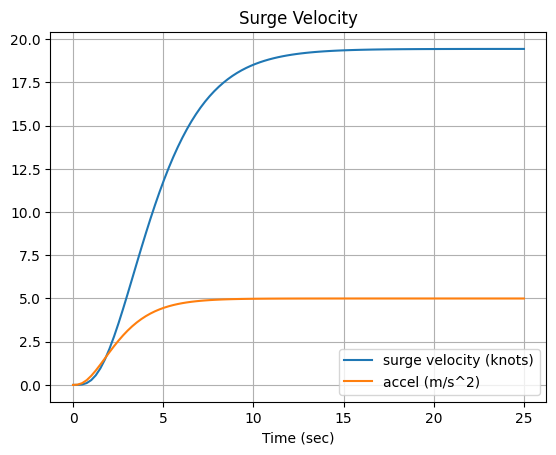

In [86]:
# Plot the results
plt.figure()
plt.grid()
plt.plot(vel_t, vel_x[2,:] * MPS_TO_KNOTS, label="surge velocity (knots)")
plt.plot(vel_t, vel_x[3,:], label="accel (m/s^2)")
plt.legend()
plt.xlabel("Time (sec)")
plt.title("Surge Velocity")
plt.show()

In [87]:
max(vel_x[2,:])

9.999702787761985

# Lateral System

## Rudder

**Target:**
- Stable Response
- Less than 7 deg/s rudder rate

In [5]:
# Rudder linear system
rud_A = np.array([[0, 1.0], [-1, -3]])
rud_B = np.array([[0], [1]])
rud_C = np.array([1, 0])
rud_D = 0

# Make the state space
rud_ss = ss(rud_A, rud_B, rud_C, rud_D)

In [6]:
rud_ss

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

In [7]:
# Simulate a forced response ot the desired rudder angle
rud_setpoint = np.radians(20)
t_f = 25
T = np.linspace(0, t_f, round(t_f / 0.001))
U = np.ones_like(T) * rud_setpoint
X0 = np.array([[0],[0]])
rud_result = forced_response(rud_ss, T, U, X0)

# Process results
rud_t = rud_result.time
rud_x = np.squeeze(rud_result.states)

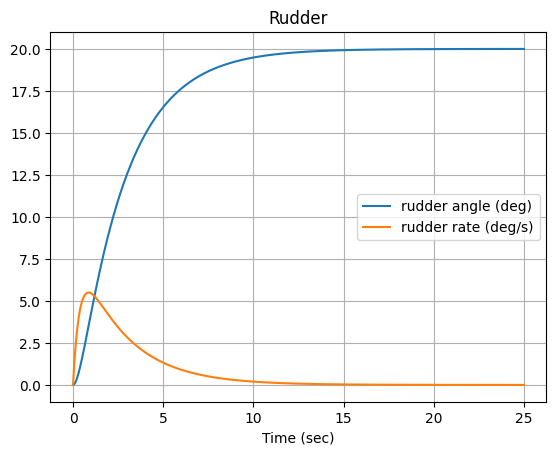

In [8]:
# Plot the results
plt.figure()
plt.grid()
plt.plot(rud_t, np.degrees(rud_x[0,:]), label="rudder angle (deg)")
plt.plot(rud_t, np.degrees(rud_x[1,:]), label="rudder rate (deg/s)")
plt.legend()
plt.xlabel("Time (sec)")
plt.title("Rudder")
plt.show()

## Yaw
**Target**:
- A maximum speed and maximum rudder: no more than 10.5 deg/s 

In [18]:
# Yaw is scheduled on speed (m/s). Assume constant speed in this analysis
# Max speed
MAX_SPEED = 10

# Analyzed speed
speed = 10

# Speed is quadratically scheduled
# If we allow reverse thrust, a sign term should be added to this to reverse response
speed_factor = (speed / MAX_SPEED) ** 2

In [30]:
# Surge velocity linear system
yaw_A = np.array([[0.0, 1.0], [0, -0.99]])
yaw_B = np.array([[0], [0.05 * speed_factor]])
yaw_C = np.eye(2, 2)
yaw_D = np.zeros_like(yaw_B)

# Make the state space
yaw_ss = ss(yaw_A, yaw_B, yaw_C, yaw_D)

# Make the overall system
yaw_sys = series(rud_ss, yaw_ss)

In [31]:
# Simulate a forced response ot the desired rudder angle
rud_setpoint = np.radians(20)
t_f = 25
T = np.linspace(0, t_f, round(t_f / 0.001))
U = np.ones_like(T) * rud_setpoint
X0 = np.zeros((4,1))
yaw_result = forced_response(yaw_sys, T, U, X0)

# Process results
yaw_t = yaw_result.time
yaw_x = np.squeeze(yaw_result.states)

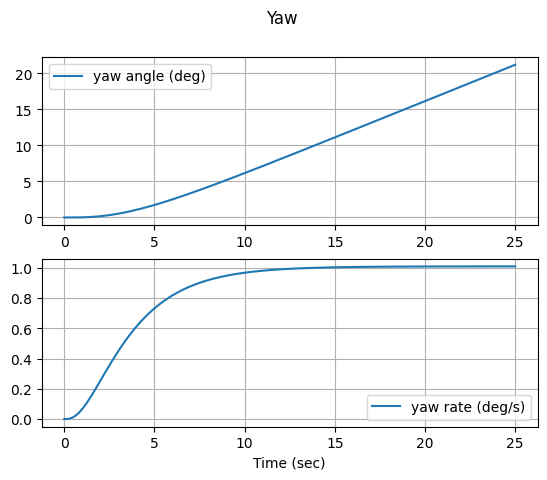

In [32]:
# Plot the yaw results
fig, axs = plt.subplots(2,1)
axs[0].grid()
axs[0].plot(yaw_t, np.degrees(yaw_x[2,:]), label="yaw angle (deg)")
axs[0].legend()

axs[1].grid()
axs[1].plot(yaw_t, np.degrees(yaw_x[3,:]), label="yaw rate (deg/s)")
axs[1].legend()
plt.xlabel("Time (sec)")
plt.suptitle("Yaw")
plt.show()

In [29]:
np.degrees(max(yaw_x[3,:]))

0.2019927579144311